# Simple Data Analysis

A jupyter notebook analyzing a simple dataset as a reference for some important skills and useful techniques.

## Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
sns.set_style("darkgrid")

In [8]:
# Small dataset containing information about customers and their purchases over a two-year time frame.
customer_data = pd.read_csv('customer-info.csv')
order_data = pd.read_csv('order-info.csv')

# Minor preprocessing: fix issue where one of the types is str, not date.
customer_data['Order Date'] = pd.to_datetime(customer_data['Order Date'])

print("Customer Data Number of Records:", len(customer_data))
print("Order Data Number of Records:   ", len(order_data))

Customer Data Number of Records: 500
Order Data Number of Records:    1500


![title](er-diagram.png)

In [9]:
customer_data.head()

,Order ID,Order Date,CustomerName,State,City
0,B-25601,2018-01-04,Bharat,Gujarat,Ahmedabad
1,B-25602,2018-01-04,Pearl,Maharashtra,Pune
2,B-25603,2018-03-04,Jahan,Madhya Pradesh,Bhopal
3,B-25604,2018-03-04,Divsha,Rajasthan,Jaipur
4,B-25605,2018-05-04,Kasheen,West Bengal,Kolkata


In [10]:
order_data.head()

,Order ID,Revenue,Profit,Quantity,Category,Sub-Category
0,B-25601,1275,-1148,7,Furniture,Bookcases
1,B-25601,66,-12,5,Clothing,Stole
2,B-25601,8,-2,3,Clothing,Hankerchief
3,B-25601,80,-56,4,Electronics,Electronic Games
4,B-25602,168,-111,2,Electronics,Phones


In [11]:
print("Unique Customers:", customer_data['CustomerName'].unique().size)
print("Unique States:", customer_data['State'].unique().size)
print("Unique Cities:", customer_data['City'].unique().size)
print("Unique Product Categories:", order_data['Category'].unique().size)
print("Unique Sub-Categories:", order_data['Sub-Category'].unique().size)

Unique Customers: 332
Unique States: 19
Unique Cities: 24
Unique Product Categories: 3
Unique Sub-Categories: 17


## Who are the most and least profitable customers?

### Customers Sorted by Profit

In [12]:
# The equivalent SQL query performed below but with pandas dataframes is:
# SELECT
#     customers.CustomerName
#     ,SUM(Profit) AS TotalProfit
# FROM customers
# INNER JOIN orders ON customers.OrderID = orders.OrderID
# GROUP BY customers.CustomerName
# ORDER BY TotalProfit DESC;

# Perform an inner join of `customer_data` and `order_data` on `Order ID` so we can associate customers with their orders.
customers_and_orders = pd.merge(customer_data, order_data, on='Order ID')
customers_and_orders.head()

,Order ID,Order Date,CustomerName,State,City,Revenue,Profit,Quantity,Category,Sub-Category
0,B-25601,2018-01-04,Bharat,Gujarat,Ahmedabad,1275,-1148,7,Furniture,Bookcases
1,B-25601,2018-01-04,Bharat,Gujarat,Ahmedabad,66,-12,5,Clothing,Stole
2,B-25601,2018-01-04,Bharat,Gujarat,Ahmedabad,8,-2,3,Clothing,Hankerchief
3,B-25601,2018-01-04,Bharat,Gujarat,Ahmedabad,80,-56,4,Electronics,Electronic Games
4,B-25602,2018-01-04,Pearl,Maharashtra,Pune,168,-111,2,Electronics,Phones


In [13]:
# Group the data by customer name, and sum over order profits.
customers_by_total_profit = \
    customers_and_orders.groupby(['CustomerName'], as_index=False).agg({'Profit': 'sum'})

customers_by_total_profit.sort_values('Profit', ascending=False, inplace=True)

print('Top 10: Most Profitable Customers')
print(customers_by_total_profit.iloc[0:10], '\n')

print('Bottom 10: Least Profitable Customers')
print(customers_by_total_profit.iloc[-10:])

Top 10: Most Profitable Customers
    CustomerName  Profit
248        Seema    1970
6       Abhijeet    1562
213     Priyanka    1340
8       Abhishek    1314
243       Sarita    1265
299      Swapnil    1215
203   Pournamasi    1027
96        Gaurav    1011
197        Pearl     995
325     Vishakha     966 

Bottom 10: Least Profitable Customers
    CustomerName  Profit
77        Chirag    -731
19        Akshay    -751
157        Mohan    -870
227       Rutuja    -900
306        Tanvi    -916
245      Sauptik    -927
247         Savi    -980
64        Bharat   -1153
1        Aarushi   -1669
257       Shishu   -1836


## Compute Customer Lifetime Value Metric

In [14]:
# Compute a simple Customer Lifetime Value Metric (CLV) as:
# CLV = average order value (revenue) x
#       average number of orders per month x
#       average customer lifetime (in months)
    
consolidated_orders = customers_and_orders.groupby('Order ID', as_index=False).agg(
    {'Revenue': 'sum', 'Order Date': 'first', 'CustomerName': 'first'})
avg_order_value = consolidated_orders['Revenue'].mean()

# Group orders by month to compute the average number of orders per month.
def clip_to_month(x):
    return datetime.datetime(x['Order Date'].year, x['Order Date'].month, 1, 0, 0)

consolidated_orders['Order Month'] = consolidated_orders.apply(clip_to_month, axis=1)
avg_orders_per_month = consolidated_orders.groupby('Order Month').size().mean()

# Compute average time window over which a customer has bought.
def customer_lifetime(x):
    """ Customer life time in months. """
    # if customer has only 1 order, say customer has a lifetime of 1 month
    if len(x) == 1:
        return 1
    return (max(x['Order Month']) - min(x['Order Month'])) / np.timedelta64(1, "M")

avg_customer_lifetime = consolidated_orders.groupby('CustomerName').apply(customer_lifetime).mean()

clv = avg_order_value * avg_orders_per_month * avg_customer_lifetime
print("Average Order Value (Revenue): %4.3f" % avg_order_value)
print("Average Orders Per Month:      %4.3f" % avg_orders_per_month)
print("Average Lifetime (Months):     %4.3f" % avg_customer_lifetime)
print("Customer Lifetime Value (CLV): %4.3f" % clv)

Average Order Value (Revenue): 863.004
Average Orders Per Month:      20.833
Average Lifetime (Months):     3.531
Customer Lifetime Value (CLV): 63481.421


## What are the most and least profitable products? 

In [15]:
# Gruop the order data by category and sum over profits.
categories_by_total_profit = \
    order_data.groupby(['Category'], as_index=False).agg({
   'Profit': 'sum',
})
    
categories_by_total_profit.sort_values('Profit', ascending=False, inplace=True)
print('Categories Sorted by Profitability:')
print(categories_by_total_profit, '\n')

subcategories_by_total_profit = \
    order_data.groupby(['Sub-Category'], as_index=False).agg({
   'Profit': 'sum',
})
    
subcategories_by_total_profit.sort_values('Profit', ascending=False, inplace=True)
print('Top 5: Most Profitable Sub-Categories')
print(subcategories_by_total_profit.iloc[0:5], '\n')

print('Bottom 5: Least Profitable Sub-Cagories')
print(subcategories_by_total_profit.iloc[-5:])

Categories Sorted by Profitability:
      Category  Profit
0     Clothing   11163
1  Electronics   10494
2    Furniture    2298 

Top 5: Most Profitable Sub-Categories
   Sub-Category  Profit
9      Printers    5964
1     Bookcases    4888
0   Accessories    3559
16     Trousers    2847
13        Stole    2559 

Bottom 5: Least Profitable Sub-Cagories
        Sub-Category  Profit
7           Leggings     260
12             Skirt     235
6              Kurti     181
3   Electronic Games   -1236
15            Tables   -4011


## What characteristics of an order make it more profitable?

### Impact of Order Origin on Profit

LeveneResult(statistic=0.9737512346567473, pvalue=0.48776681815062084)
LeveneResult(statistic=0.9804754140967316, pvalue=0.4879328275281709)


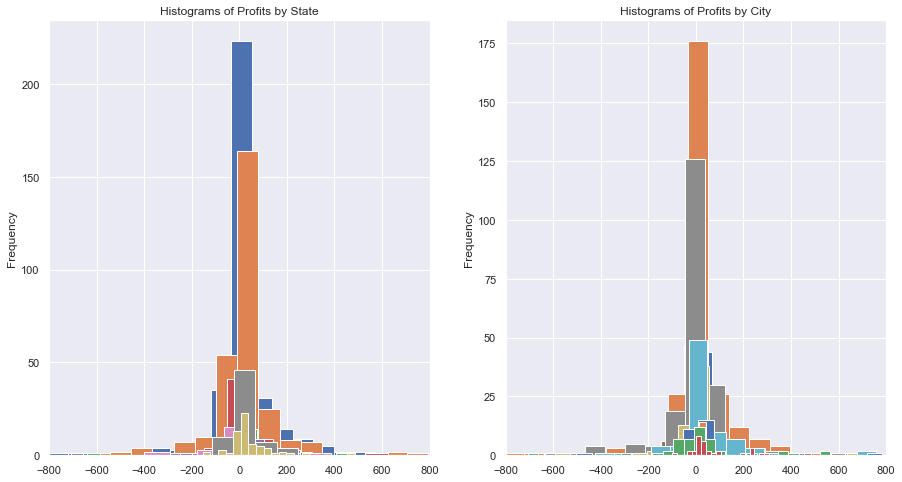

In [16]:
sns.set(rc = {'figure.figsize':(15,8)})

# In order to justify using an ANOVA test to determine the impact of order origin on profit:
# (1) Check that the profits for each state/city are approximately normally distributed.
#     - Can do this visually with histograms, QQ-plots, and with a normality test, like Shapiro-Wilk.
# (2) Use the Levene test to see if the samples have homogeneity of variance (HOV).
# (3) Observations of profits for each order are independent (reasonable assumption here).

fig, (ax1, ax2) = plt.subplots(1, 2)

customers_and_orders.groupby('State')['Profit'].plot(kind='hist', xlim=(-800, 800), ax=ax1, bins=20, \
                                                                title='Histograms of Profits by State');
customers_and_orders.groupby('City')['Profit'].plot(kind='hist', xlim=(-800, 800), ax=ax2, bins=20, \
                                                                title='Histograms of Profits by City');

profits_per_state = [data for (_, data) in customers_and_orders.groupby('State')['Profit']] 
profits_per_city = [data for (_, data) in customers_and_orders.groupby('City')['Profit']] 

print(stats.levene(*profits_per_state, center='median', proportiontocut=0.05))
print(stats.levene(*profits_per_city, center='median', proportiontocut=0.05))

# The null hypothesis for the Levene test: The samples of profits from states/cities come from populations with equal
# variances. For both states and cities, since the Levene tests' pvalues are > 0.05, we cannot reject the null hypothesis.
# Therefore, we provide evidence that there is homogeneity of variance.

In [17]:
# Perform one-way ANOVA tests to determine the impact of order origin on profit.
f_states, p_states = stats.f_oneway(*profits_per_state, axis=0)
f_cities, p_cities = stats.f_oneway(*profits_per_city, axis=0)

num_states, num_cities, num_records = len(profits_per_state), len(profits_per_city), len(customers_and_orders)
f_crit_states = stats.f.ppf(q=1-0.05, dfn=num_states - 1, dfd=num_records - num_states)
f_crit_cities = stats.f.ppf(q=1-0.05, dfn=num_cities - 1, dfd=num_records - num_cities)

print("States: F/F_crit = %1.3f, p-value = %1.3f" % (f_states / f_crit_states, p_states))
print("Cities: F/F_crit = %1.3f, p-value = %1.3f" % (f_cities / f_crit_cities, p_cities))

# The null hypothesis for the ANOVA test: There is no difference in mean profit among states or cities.
# In the case of states, since F/F_crit < 1, and p-value > 0.05, we cannot reject the null hypothesis.
# However, in the case of cities, since F/F_crit > 1 and p-value < 0.05, we can reject the null hypothesis. 
# There is statistically significant evidence that what city an order comes from has an impact on profitability.

States: F/F_crit = 0.756, p-value = 0.237
Cities: F/F_crit = 1.090, p-value = 0.024


### Impact of Order Revenue/Quantity on Profit

Rvalue:  0.24204459835018005


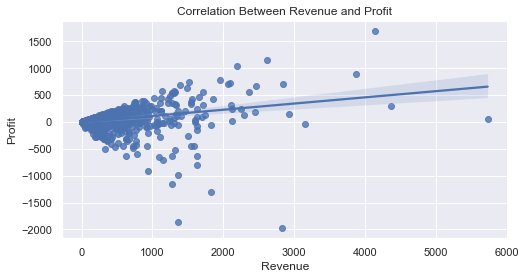

In [18]:
sns.set(rc = {'figure.figsize':(8,4)})

ax = sns.regplot(x=customers_and_orders['Revenue'], y=customers_and_orders['Profit'], robust=True);
ax.set_title('Correlation Between Revenue and Profit');

result = stats.linregress(customers_and_orders['Revenue'], customers_and_orders['Profit'])
print("Rvalue: ", result.rvalue)

# We see a slight positive correlation between order revenue and profit, though note this could be skewed by
# the few outliers of high revenue items being profitable.

Rvalue:  0.0024413603969613614


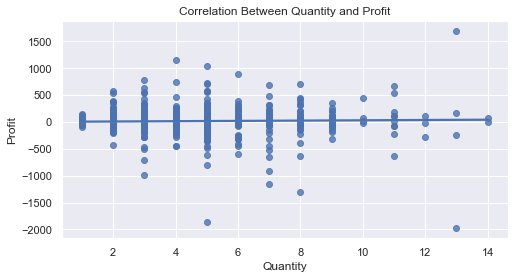

In [19]:
ax = sns.regplot(x=customers_and_orders['Quantity'], y=customers_and_orders['Profit'], robust=True);
ax.set_title('Correlation Between Quantity and Profit');

result = stats.linregress(customers_and_orders['Quantity'], customers_and_orders['Profit'])
print("Rvalue: ", result.rvalue)

# We see almost no correlation between order quantity and profit.

## Which products are projected to have the most sales?

### Product Sales by Category Over Time

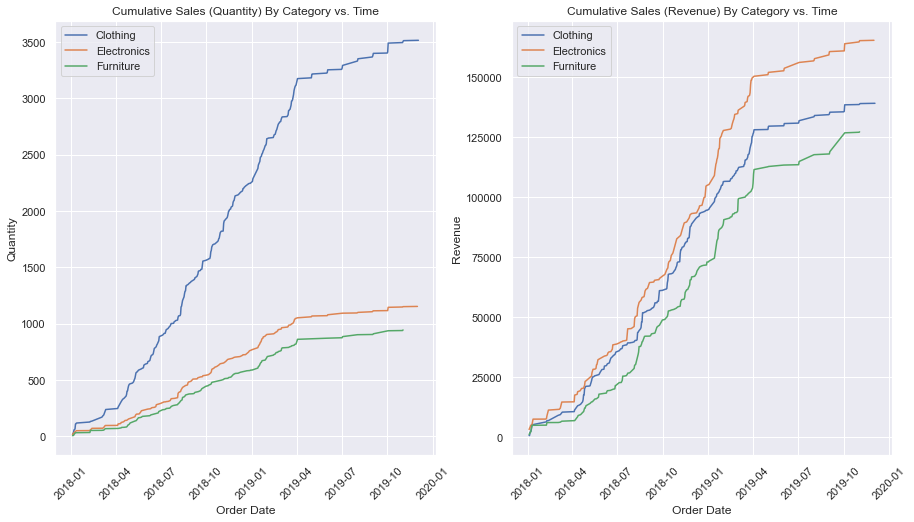

In [21]:
sns.set(rc = {'figure.figsize':(15,8)})

products_grouped_by_category = customers_and_orders.groupby(['Category'], as_index=False)

fig, (ax1, ax2) = plt.subplots(1, 2)

for (category, group) in products_grouped_by_category:
    # Consolidate orders of the same item on the same date to ensure plotting matches actual cumulative sum.
    # Plotting only picks one point per date.
    group = group.groupby(['Order Date'], as_index=False).sum()
    group.sort_values('Order Date', ascending=True, inplace=True)
    sns.lineplot(x=group['Order Date'], y=group['Quantity'].cumsum(), legend="full", ax=ax1, label=category)
    sns.lineplot(x=group['Order Date'], y=group['Revenue'].cumsum(), legend="full", ax=ax2, label=category)

ax1.set_title('Cumulative Sales (Quantity) By Category vs. Time');
ax1.tick_params(axis='x', rotation=45)

ax2.set_title('Cumulative Sales (Revenue) By Category vs. Time');
ax2.tick_params(axis='x', rotation=45)

# The plots below shows that the `Clothing` category dominates sales in terms of `Quantity`, but `Electronics`
# leads sales in terms of `Revenue`.

### Product Sales by Sub-Category Over Time

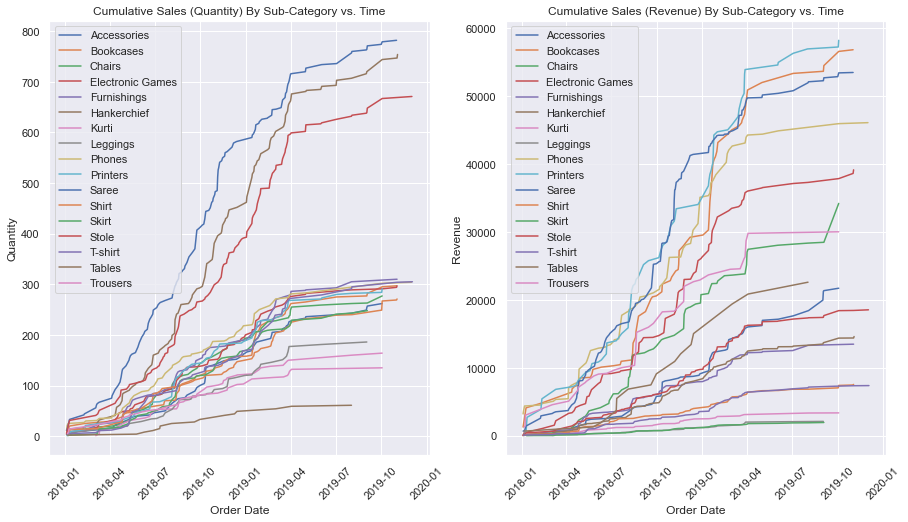

In [22]:
sns.set(rc = {'figure.figsize':(15,8)})

products_grouped_by_subcategory = customers_and_orders.groupby(['Sub-Category'], as_index=False)

fig, (ax1, ax2) = plt.subplots(1, 2)

for (subcategory, group) in products_grouped_by_subcategory:
    # Consolidate orders of the same item on the same date to ensure plotting matches actual cumulative sum.
    # Plotting only picks one point per date.
    group = group.groupby(['Order Date'], as_index=False).agg({'Quantity': 'sum', 'Revenue': 'sum'})
    group.sort_values('Order Date', ascending=True, inplace=True)
    sns.lineplot(x=group['Order Date'], y=group['Quantity'].cumsum(), ax=ax1, label=subcategory)
    sns.lineplot(x=group['Order Date'], y=group['Revenue'].cumsum(), ax=ax2, label=subcategory)

ax1.legend()
ax1.set_title('Cumulative Sales (Quantity) By Sub-Category vs. Time');
ax1.tick_params(axis='x', rotation=45)

ax2.legend()
ax2.set_title('Cumulative Sales (Revenue) By Sub-Category vs. Time');
ax2.tick_params(axis='x', rotation=45)

# Projection In Terms of `Quantity` (Sales Volume):
#
# The three dominant items by cumulative sales as of Nov 2019: (1) Sarees, (2) Handkerchiefs, (3) Stoles
#
# The products projected to have the most sales by quantity in 2020 Q1 are sarees or handkerchiefs.
# While sarees had the highest cumulative sales as of November 2019, a slight uptrend in handkerchiefs
# from September to November 2019 makes it possible that it could overtake sarees by the end of Q1 2020.


# Projection in Terms of `Revenue` (Sales Revenue):
#
# The three dominant items by cumulative sales as of Nov 2019: (1) Printers, (2) Bookcases, (3) Sarees
#
# The products projected to have the most sales by revenue in 2020 Q1 will be printers or bookcases.
# While printers had the highest cumulative sales as of October 2019, an uptrend in bookcases from
# September to November 2019 makes it possible that it could overtake printers by the end of Q1 2020.


# Interesting Observation:
# We observe in the plots that the sales rate changed dramatically around April 2019, likely due to an
# economic slowdown caused by inverted yield curve and China-US trade war fears.